<a href="https://colab.research.google.com/github/iKatePy/Study_projects/blob/master/Augmentation_HomeWork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнее задание: аугментация датасета

Домашнее задание состоит из трех частей:
1. Загрузка и предобработка датасета. Скачать датасет можно по ссылке: https://www.kaggle.com/datasets/vencerlanz09/healthy-and-bleached-corals-image-classification Ожидаемый результат - numpy массив images с изображениями из датасета, приведенными к единому размеру: 100х100x3 с сохранением соотношения сторон.
2. Написание классов-оберток для функций преобразований, чтобы осущесвлять случайные преобразования. Ожидаемый результат - корректно работающие обертки для любых 3 цветовых преобразований, любых 5 геометических, 1 наложения шума или сглаживания на выбор.
3. Применение аугментации. Ожидаемый результат - 5 аугментированных изображений.

В конце сохраните ноутбук вместе с результатами выполнения ячеек.

## Загрузка и предобработка датасета

In [ ]:
import os
import cv2
import numpy as np
from PIL import Image, ImageOps
from tqdm import tqdm
import kagglehub

In [ ]:
DATASET_PATH = kagglehub.dataset_download("vencerlanz09/healthy-and-bleached-corals-image-classification")

In [ ]:
def resize_with_aspect(img, size=(100, 100)):
    """
    Масштабирование изображения с сохранением соотношения сторон.
    Добавляет черные поля (padding) по необходимости.
    """
    old_h, old_w = img.shape[:2]
    new_h, new_w = size
    ar = old_h / old_w

    if ar > 1:  # вертикальное изображение
        factor = new_h / old_h
        resize_h = new_h
        resize_w = int(old_w * factor)
    else:  # горизонтальное изображение или квадрат
        factor = new_w / old_w
        resize_w = new_w
        resize_h = int(old_h * factor)

    resized_img = cv2.resize(img, (resize_w, resize_h), interpolation=cv2.INTER_AREA)
    new_img = np.zeros((new_h, new_w, 3), dtype=img.dtype)
    start_y = (new_h - resize_h) // 2
    start_x = (new_w - resize_w) // 2
    new_img[start_y:start_y+resize_h, start_x:start_x+resize_w] = resized_img
    return new_img

# Сбор путей ко всем изображениям в датасете
image_paths = []
for root, dirs, files in os.walk(DATASET_PATH):
    for file in files:
        if file.lower().endswith(('.jpg', '.jpeg', '.png')):
            image_paths.append(os.path.join(root, file))

# Загрузка и масштабирование изображений
images = []
for path in tqdm(image_paths[:50], desc="Processing images"):  # для примера возьмём первые 50
    img = cv2.imread(path)
    if img is not None:
        img = resize_with_aspect(img, (100, 100))
        images.append(img)
images = np.stack(images)
print('Shape of images:', images.shape)  # (num_images, 100, 100, 3)

Processing images: 100%|██████████| 50/50 [00:00<00:00, 413.22it/s]

Shape of images: (50, 100, 100, 3)


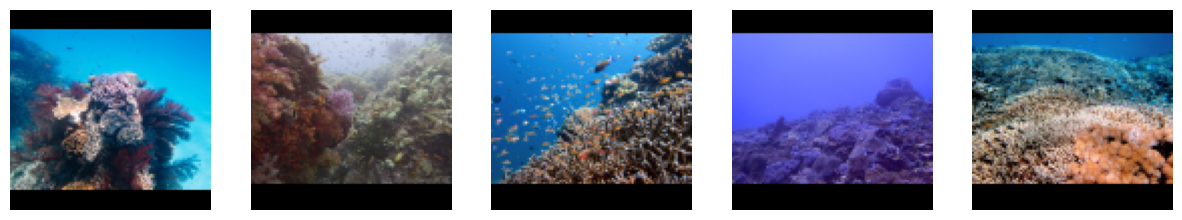

In [ ]:
from matplotlib import pyplot as plt

# Создание фигуры и осей
f, axes = plt.subplots(1, 5, figsize=(15, 5))

# Вывод изображений
for i in range(5):
    axes[i].imshow(images[i][..., ::-1])  # Преобразование BGR в RGB
    axes[i].axis('off')  # Отключение осей

for ax in axes:
    ax.axis('off')

plt.show()

## Написание оберток для функций преобразований

Обёртки для цветовых преобразований

In [ ]:
import random

def change_brightness(img, delta):
    # Изменение яркости на delta (положительное или отрицательное)
    return cv2.convertScaleAbs(img, alpha=1, beta=delta)

def change_contrast(img, factor):
    # Изменение контрастности с коэффициентом factor
    return cv2.convertScaleAbs(img, alpha=factor, beta=0)

def change_saturation(img, factor):
    # Изменение насыщенности с коэффициентом factor
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV).astype(np.float32)
    hsv[..., 1] = np.clip(hsv[..., 1] * factor, 0, 255)
    hsv = hsv.astype(np.uint8)
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

class RandomBrightness:
    def __init__(self, delta_range=(-40, 40), prob=0.5):
        self.delta_range = delta_range
        self.prob = prob
    def __call__(self, img):
        if random.random() < self.prob:
            delta = random.randint(*self.delta_range)
            return change_brightness(img, delta)
        return img

class RandomContrast:
    def __init__(self, factor_range=(0.7, 1.3), prob=0.5):
        self.factor_range = factor_range
        self.prob = prob
    def __call__(self, img):
        if random.random() < self.prob:
            factor = random.uniform(*self.factor_range)
            return change_contrast(img, factor)
        return img

class RandomSaturation:
    def __init__(self, factor_range=(0.7, 1.3), prob=0.5):
        self.factor_range = factor_range
        self.prob = prob
    def __call__(self, img):
        if random.random() < self.prob:
            factor = random.uniform(*self.factor_range)
            return change_saturation(img, factor)
        return img

Обёртки для геометрических преобразований

In [ ]:
def flip(img, mode):
    # Отражение изображения: mode может быть 'horizontal' или 'vertical'
    if mode == 'horizontal':
        return cv2.flip(img, 1)
    elif mode == 'vertical':
        return cv2.flip(img, 0)
    else:
        return img

class RandomFlip:
    def __init__(self, prob=0.5):
        self.prob = prob
    def __call__(self, img):
        if random.random() < self.prob:
            mode = random.choice(['horizontal', 'vertical'])
            return flip(img, mode)
        return img

def zoom_in(img, factor):
    # Приближение изображения с масштабом factor > 1
    h, w = img.shape[:2]
    M = cv2.getRotationMatrix2D(center=(w/2, h/2), angle=0, scale=factor)
    zoomed = cv2.warpAffine(img, M, (w, h))
    return zoomed

class RandomZoomIn:
    def __init__(self, factor_range=(1.1, 1.5), prob=0.5):
        self.factor_range = factor_range
        self.prob = prob
    def __call__(self, img):
        if random.random() < self.prob:
            factor = random.uniform(*self.factor_range)
            return zoom_in(img, factor)
        return img

def rotate(img, angle):
    # Поворот изображения на угол angle (градусы)
    h, w = img.shape[:2]
    center = (w//2, h//2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(img, M, (w, h))
    return rotated

class RandomRotate:
    def __init__(self, angle_range=(-30, 30), prob=0.5):
        self.angle_range = angle_range
        self.prob = prob
    def __call__(self, img):
        if random.random() < self.prob:
            angle = random.uniform(*self.angle_range)
            return rotate(img, angle)
        return img

def translate(img, dx, dy):
    # Сдвиг изображения на dx, dy пикселей
    h, w = img.shape[:2]
    M = np.float32([[1, 0, dx], [0, 1, dy]])
    translated = cv2.warpAffine(img, M, (w, h))
    return translated

class RandomTranslate:
    def __init__(self, max_shift=10, prob=0.5):
        self.max_shift = max_shift
        self.prob = prob
    def __call__(self, img):
        if random.random() < self.prob:
            dx = random.randint(-self.max_shift, self.max_shift)
            dy = random.randint(-self.max_shift, self.max_shift)
            return translate(img, dx, dy)
        return img

def crop(img, x, y, h, w):
    # Вырезание области (x, y, h, w)
    return img[y:y+h, x:x+w]

class RandomCrop:
    def __init__(self, crop_size=(80, 80), prob=0.5):
        self.crop_size = crop_size
        self.prob = prob
    def __call__(self, img):
        h, w = img.shape[:2]
        ch, cw = self.crop_size
        if ch > h or cw > w:
            return img
        if random.random() < self.prob:
            x = random.randint(0, w - cw)
            y = random.randint(0, h - ch)
            cropped = crop(img, x, y, ch, cw)
            # Возвращаем к исходному размеру с сохранением пропорций
            return resize_with_aspect(cropped, (100, 100))
        return img

Обертка для шума

In [ ]:
from skimage.util import random_noise

def add_gaussian_noise(img, var=0.01):
    # Добавление гауссовского шума
    img_float = img.astype(np.float32) / 255.0
    noisy = random_noise(img_float, mode='gaussian', var=var)
    noisy_uint8 = (noisy * 255).astype(np.uint8)
    return noisy_uint8

class RandomGaussianNoise:
    def __init__(self, var_range=(0.005, 0.02), prob=0.5):
        self.var_range = var_range
        self.prob = prob
    def __call__(self, img):
        if random.random() < self.prob:
            var = random.uniform(*self.var_range)
            return add_gaussian_noise(img, var)
        return img

## Применение аугментации

In [ ]:
augmentation_steps = [RandomBrightness(prob=0.5),
    RandomContrast(prob=0.5),
    RandomSaturation(prob=0.5),
    RandomFlip(prob=0.5),
    RandomZoomIn(prob=0.5),
    RandomRotate(prob=0.5),
    RandomTranslate(max_shift=10, prob=0.5),
    RandomCrop(crop_size=(80, 80), prob=0.5),
    RandomGaussianNoise(var_range=(0.005, 0.02), prob=0.5)]

# Применение аугментации
for i in range(images.shape[0]):
    for transform in augmentation_steps:
        images[i] = transform(images[i])

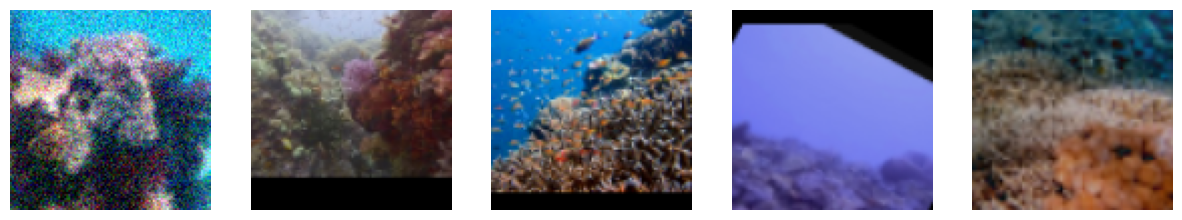

In [ ]:
# Вывод результата - аугментированных изображений

from matplotlib import pyplot as plt

f, axes = plt.subplots(1, 5, figsize=(15, 5))

for i in range(5):
    axes[i].imshow(images[i][..., ::-1])
    axes[i].axis('off')  # Отключаем оси

plt.show()